### Import required libraries

In [ ]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import DynamicEdgeConv, MessagePassing, knn_graph
from torch.nn import Sequential as Seq, Linear, ReLU

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, Normalizer

### Selecting Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load traning and test data and Concatinate them

In [ ]:
df_train = pd.read_csv('trainingData_mod.csv')

In [ ]:
missing = 0.0
if missing > 0:
    df_train = df_train.sample(frac=1-missing, random_state=42)

In [ ]:
df_val = pd.read_csv('validationData_mod.csv')

train_numb = len(df_train)
test_numb = len(df_val)

df = pd.concat([df_train, df_val])
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,DRSS520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,0,0,0,0,0,0,0,0,0,0,...,0.0,-7541.264300,4.864921e+06,2,1,106,2,2,23,1371713733
1,0,0,0,0,0,0,0,0,0,0,...,0.0,-7536.621200,4.864934e+06,2,1,106,2,2,23,1371713691
2,0,0,0,0,0,0,0,7,0,0,...,0.0,-7519.152400,4.864950e+06,2,1,103,2,2,23,1371714095
3,0,0,0,0,0,0,0,0,0,0,...,0.0,-7524.570400,4.864934e+06,2,1,102,2,2,23,1371713807
4,0,0,0,0,0,0,0,0,0,0,...,0.0,-7632.143600,4.864982e+06,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0.0,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,0,0,0,0,0,0,0,0,0,0,...,0.0,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,0,0,0,0,0,0,0,0,0,0,...,0.0,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,0,0,0,0,0,0,0,0,0,0,...,0.0,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


### Create Classes for classification

In [ ]:
df['CLASS'] = df['BUILDINGID'].astype(str) + df['FLOOR'].astype(str)
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,CLASS
0,0,0,0,0,0,0,0,0,0,0,...,-7541.264300,4.864921e+06,2,1,106,2,2,23,1371713733,12
1,0,0,0,0,0,0,0,0,0,0,...,-7536.621200,4.864934e+06,2,1,106,2,2,23,1371713691,12
2,0,0,0,0,0,0,0,7,0,0,...,-7519.152400,4.864950e+06,2,1,103,2,2,23,1371714095,12
3,0,0,0,0,0,0,0,0,0,0,...,-7524.570400,4.864934e+06,2,1,102,2,2,23,1371713807,12
4,0,0,0,0,0,0,0,0,0,0,...,-7632.143600,4.864982e+06,0,0,122,2,11,13,1369909710,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711,23
1107,0,0,0,0,0,0,0,0,0,0,...,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730,23
1108,0,0,0,0,0,0,0,0,0,0,...,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781,00
1109,0,0,0,0,0,0,0,0,0,0,...,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807,00


In [ ]:
no_out = len(df['CLASS'].unique())

In [ ]:
df_y = df[["CLASS"]]
df_y

,CLASS
0,12
1,12
2,12
3,12
4,00
...,...
1106,23
1107,23
1108,00
1109,00


In [ ]:
enc = OrdinalEncoder(dtype=np.int32)
y = enc.fit_transform(df_y['CLASS'].values.reshape(-1,1))
y = y.reshape(-1,)

In [ ]:
y.max()

12

In [ ]:
y

array([6, 6, 6, ..., 0, 0, 0])

### Seperate Input and Output

In [ ]:
df_x = df.iloc[: , :1040]

df_x

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,DRSS511,DRSS512,DRSS513,DRSS514,DRSS515,DRSS516,DRSS517,DRSS518,DRSS519,DRSS520
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,7,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1109,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Split data into train and test sets
X_train = df_x[:len(df_train)]
X_test = df_x[len(df_train):]
y_train = y[:len(df_train)]
y_test = y[len(df_train):]

### Scale the input features

In [ ]:
norm_scl = Normalizer()

norm_scl.fit(X_train)

Normalizer()

In [ ]:
df_x = norm_scl.transform(df_x)

In [ ]:
X_train = norm_scl.transform(X_train)
X_test = norm_scl.transform(X_test)

In [ ]:
len(X_train[0])

1040

### KNN Classifier

In [ ]:
acc_list =[]
for K in range(1, 60):
    knn = KNeighborsClassifier(n_neighbors=K, weights='distance')

    # Train the model on the training set
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc.item())
    print("K = ", K, "Accuracy_score: {:.4f}".format(acc))

K =  1 Accuracy_score: 0.9370
K =  2 Accuracy_score: 0.9370
K =  3 Accuracy_score: 0.9352
K =  4 Accuracy_score: 0.9352
K =  5 Accuracy_score: 0.9406
K =  6 Accuracy_score: 0.9388
K =  7 Accuracy_score: 0.9442
K =  8 Accuracy_score: 0.9397
K =  9 Accuracy_score: 0.9415
K =  10 Accuracy_score: 0.9406
K =  11 Accuracy_score: 0.9379
K =  12 Accuracy_score: 0.9388
K =  13 Accuracy_score: 0.9361
K =  14 Accuracy_score: 0.9379
K =  15 Accuracy_score: 0.9388
K =  16 Accuracy_score: 0.9388
K =  17 Accuracy_score: 0.9361
K =  18 Accuracy_score: 0.9379
K =  19 Accuracy_score: 0.9397
K =  20 Accuracy_score: 0.9406
K =  21 Accuracy_score: 0.9397
K =  22 Accuracy_score: 0.9406
K =  23 Accuracy_score: 0.9424
K =  24 Accuracy_score: 0.9433
K =  25 Accuracy_score: 0.9451
K =  26 Accuracy_score: 0.9442
K =  27 Accuracy_score: 0.9469
K =  28 Accuracy_score: 0.9469
K =  29 Accuracy_score: 0.9469
K =  30 Accuracy_score: 0.9469
K =  31 Accuracy_score: 0.9451
K =  32 Accuracy_score: 0.9451
K =  33 Accuracy_

Text(0.5, 1.0, 'best accuracy: 0.9513951395139514')

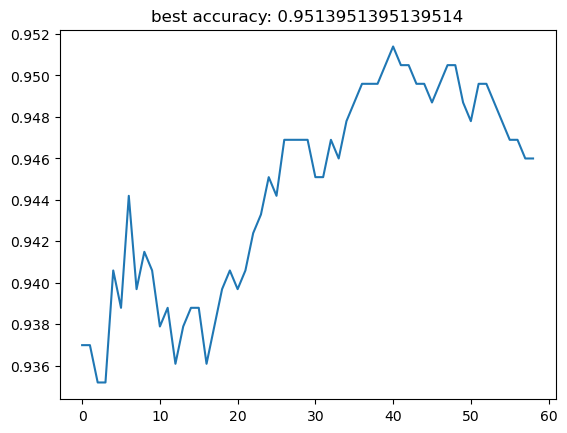

In [ ]:
plt.plot(acc_list)
plt.title(f"best accuracy: {max(acc_list)}")
# plt.savefig(f"result_part/knn_missing_{missing}.png")

### MLP Classifier

In [ ]:
def mlp_call(h_layer):
    mlp = MLPClassifier(hidden_layer_sizes=h_layer, activation='relu', solver='adam', random_state=42)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Hidden layer: {h_layer} \tAccuracy: {accuracy}")
    return accuracy

In [ ]:
h_layers = [(32), (64), (64, 32), (128), (128, 32), (256, 32), (256, 64), (512, 64), (512, 256, 64), (1024, 512, 256), (1024, 16)]
mlp_res = []
for h_layer in h_layers:
    mlp_res.append(mlp_call(h_layer))

Hidden layer: 32 	Accuracy: 0.927992799279928
Hidden layer: 64 	Accuracy: 0.9234923492349235
Hidden layer: (64, 32) 	Accuracy: 0.9198919891989199
Hidden layer: 128 	Accuracy: 0.9261926192619262
Hidden layer: (128, 32) 	Accuracy: 0.9306930693069307
Hidden layer: (256, 32) 	Accuracy: 0.9225922592259226
Hidden layer: (256, 64) 	Accuracy: 0.9243924392439244
Hidden layer: (512, 64) 	Accuracy: 0.9252925292529253
Hidden layer: (512, 256, 64) 	Accuracy: 0.9288928892889289
Hidden layer: (1024, 512, 256) 	Accuracy: 0.9351935193519352
Hidden layer: (1024, 16) 	Accuracy: 0.918091809180918


Text(0.5, 1.0, 'best accuracy: 0.9351935193519352')

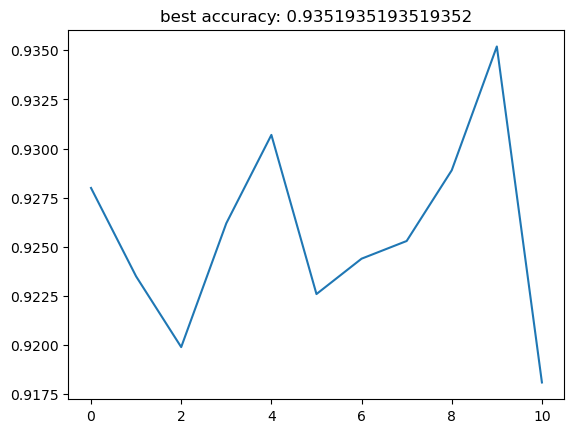

In [ ]:
plt.plot(mlp_res)
plt.title(f"best accuracy: {max(mlp_res)}")
#plt.savefig(f"../results/uji_result/mlp_missing_{missing}.png")

### SVM Classifier

In [ ]:
def svm_call(c):
    svm = SVC(kernel='rbf', C=c, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    svm_acc = accuracy_score(y_test, y_pred)
    print(f"C = {c} \tAccuracy: {svm_acc}")
    return svm_acc


In [ ]:
cs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
svm_res = []
for c in cs:
    svm_res.append(svm_call(c))

C = 0.5 	Accuracy: 0.9531953195319532
C = 0.6 	Accuracy: 0.9522952295229523
C = 0.7 	Accuracy: 0.9540954095409541
C = 0.8 	Accuracy: 0.9540954095409541
C = 0.9 	Accuracy: 0.9531953195319532
C = 1.0 	Accuracy: 0.9531953195319532
C = 1.1 	Accuracy: 0.9540954095409541
C = 1.2 	Accuracy: 0.9531953195319532
C = 1.3 	Accuracy: 0.9531953195319532
C = 1.4 	Accuracy: 0.9531953195319532
C = 1.5 	Accuracy: 0.9531953195319532


Text(0.5, 1.0, 'best accuracy: 0.9540954095409541')

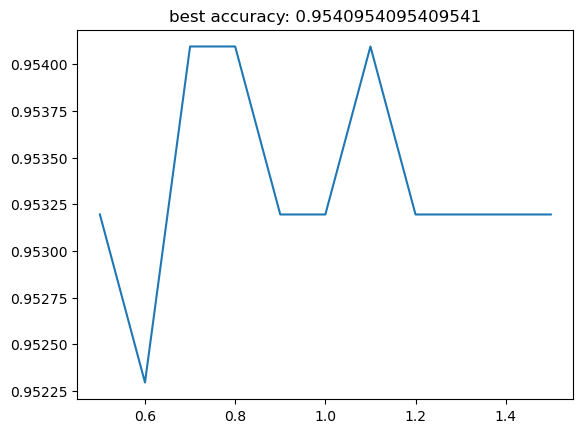

In [ ]:
plt.plot(cs, svm_res)
plt.title(f"best accuracy: {max(svm_res)}")
#plt.savefig(f"../results/uji_result/svm_missing_{missing}.png")